# Transformer Network
Here we will explore the Transformer architecture, a neural network that takes advantages of parallel processing and allows us to significantly speed up the training process.

What we are doing here: 
* Create positional encodings to capture sequential relationships in data
* Calculate scaled dot-product self-attention with word embeddings
* Implement masked multi-head attention
* Build and train a Transformer model

### Packages

In [4]:
import tensorflow as tf 
import pandas as pd 
import time 
import  numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Embedding, MultiHeadAttention, Dense, Input, Dropout, LayerNormalization
from transformers import DistilBertTokenizerFast
from transformers import TFDistilBertForTokenClassification
from tqdm import tqdm_notebook as tqdm 

2025-01-30 08:27:12.911605: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-30 08:27:12.950935: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-30 08:27:13.150422: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-30 08:27:13.151382: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-30 08:27:14.140661: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

## Positional Encoding 
In sequence to sequence tasks, the relative order of our data is extremely important
to its meaning.  However, when we train a Transformer network, we feed our data into the model all at once.
While this dramatically reduces training time, there is no information about the order of our data. This is where positional encoding is useful - we can specifically encode the positions of our inputs and pass them into the network using these sine and cosine formulas:
1. For even indices:
   $$
   PE_{(pos, 2i)} = \sin\left(\frac{pos}{10000^{\frac{2i}{d}}}\right)
   \tag{1}
   $$

2. For odd indices:
   $$
   PE_{(pos, 2i+1)} = \cos\left(\frac{pos}{10000^{\frac{2i}{d}}}\right)
   \tag{2}
   $$


### Get Angles

In [5]:
def get_angles(pos, i, d):
    """
    Get the angles for the positional encoding
    
    Arguments:
        pos -- Column vector containing the positions [[0], [1], ...,[N-1]]
        i --   Row vector containing the dimension span [[0, 1, 2, ..., M-1]]
        d(integer) -- Encoding size
    
    Returns:
        angles -- (pos, d) numpy array 
    """
    angles = pos / (np.power(10000, (2 * (i//2)) / np.float32(d)))

    return angles

In [6]:
### Sine and Cosine Positional Encodings


In [7]:
def positional_encoding(positions, d):
    """
    Precomputes a matrix with all the positional encodings 
    
    Arguments:
        positions (int) -- Maximum number of positions to be encoded 
        d (int) -- Encoding size 
    
    Returns:
        pos_encoding -- (1, position, d_model) A matrix with the positional encodings
    """
    angle_rads = get_angles(np.arange(positions)[:,np.newaxis],np.arange(d)[np.newaxis,:],d)

    #even
    angle_rads[:,0::2] = np.sin(angle_rads[:,0::2])
    #odd
    angle_rads[:,1::2] = np.cos(angle_rads[:,1::2])
    
    positional_encoding = angle_rads[np.newaxis,...]

    return tf.cast(positional_encoding, dtype=tf.float32)



(1, 50, 512)


2025-01-30 08:27:17.223521: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-01-30 08:27:17.224989: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


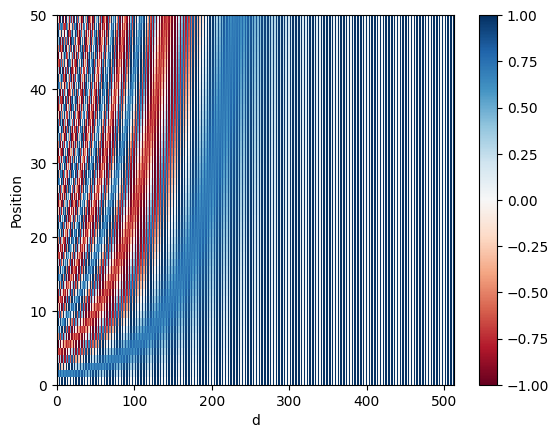

In [8]:
pos_encoding = positional_encoding(50,512)
print(pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('d')
plt.xlim((0,512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

## Masking 
There are two types of masks that are useful when building your Transformer network: the *padding mask* and the *look-ahead mask*. Both help the softmax computation give the appropriate weights to the words in your input sentence. 

### Padding Mask
Sequences are truncated or padded with zeros to achieve uniform length. However, zeros affect the softmax calculation. A padding mask multiplies these zeros by \(-1e9\), turning them into \(-1e9\), effectively masking them out. For example, \([87, 600, 0, 0, 0]\) becomes \([87, 600, -1e9, -1e9, -1e9]\), so zeros don’t impact the softmax score.

In [9]:
def create_padding_mask(seq):
    """
    Creates a matrix mask for the padding cells
    
    Arguments:
        seq -- (n, m) matrix
    
    Returns:
        mask -- (n, 1, 1, m) binary tensor
    """
    seq = tf.cast(tf.math.equal(seq,0),tf.float32)

    return seq[:,tf.newaxis,tf.newaxis,:]

In [10]:
x = tf.constant([[7., 6., 0., 0., 1.], [1., 2., 3., 0., 0.], [0., 0., 0., 4., 5.]])
print(create_padding_mask(x))

tf.Tensor(
[[[[0. 0. 1. 1. 0.]]]


 [[[0. 0. 0. 1. 1.]]]


 [[[1. 1. 1. 0. 0.]]]], shape=(3, 1, 1, 5), dtype=float32)


In [11]:
print(tf.keras.activations.softmax(x))
print(tf.keras.activations.softmax(x + create_padding_mask(x) * -1.0e9))

tf.Tensor(
[[7.2876638e-01 2.6809821e-01 6.6454895e-04 6.6454895e-04 1.8064313e-03]
 [8.4437370e-02 2.2952458e-01 6.2391245e-01 3.1062771e-02 3.1062771e-02]
 [4.8541022e-03 4.8541022e-03 4.8541022e-03 2.6502505e-01 7.2041267e-01]], shape=(3, 5), dtype=float32)
tf.Tensor(
[[[[7.2973621e-01 2.6845497e-01 0.0000000e+00 0.0000000e+00
    1.8088353e-03]
   [2.4472848e-01 6.6524088e-01 0.0000000e+00 0.0000000e+00
    9.0030566e-02]
   [6.6483538e-03 6.6483538e-03 0.0000000e+00 0.0000000e+00
    9.8670328e-01]]]


 [[[7.3057157e-01 2.6876229e-01 6.6619506e-04 0.0000000e+00
    0.0000000e+00]
   [9.0030566e-02 2.4472848e-01 6.6524088e-01 0.0000000e+00
    0.0000000e+00]
   [3.3333334e-01 3.3333334e-01 3.3333334e-01 0.0000000e+00
    0.0000000e+00]]]


 [[[0.0000000e+00 0.0000000e+00 0.0000000e+00 2.6894143e-01
    7.3105854e-01]
   [0.0000000e+00 0.0000000e+00 0.0000000e+00 5.0000000e-01
    5.0000000e-01]
   [0.0000000e+00 0.0000000e+00 0.0000000e+00 2.6894143e-01
    7.3105854e-01]]]], shape

### Look-ahead Mask
The look-ahead mask prevents the model from accessing future tokens during training, ensuring it predicts the next token based only on past and current information. For example, with an expected output `[1, 2, 3]`, the model would only see `[1, -1e9, -1e9]` to predict `[1, 2, -1e9]`.


In [12]:
def create_look_ahead_mask(size):
    """    
    Returns an upper triangular matrix filled with ones
    
    Arguments:
        size -- matrix size
    
    Returns:
        mask -- (size, size) tensor
    """
    mask = tf.linalg.band_part(tf.ones((size,size)),-1,0)
    
    return mask

In [13]:
x = tf.random.uniform((1,3))
temp = create_look_ahead_mask(x.shape[1])
temp

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[1., 0., 0.],
       [1., 1., 0.],
       [1., 1., 1.]], dtype=float32)>

## Self Attention 
As the authors of the Transformers paper state, "Attention is All You Need". 

<img src="./images/self-attention.png" alt="Encoder" width="600"/>
<caption><center><font color='white'><b> Self-Attention calculation </b>visualization</font></center></caption>
    
The use of self-attention paired with traditional convolutional networks allows for the parallization which speeds up training. We will implement **scaled dot product attention** which takes in a query, key, value, and a mask as inputs to returns rich, attention-based vector representations of the words in our sequence. This type of self-attention can be mathematically expressed as:
$$
\text { Attention }(Q, K, V)=\operatorname{softmax}\left(\frac{Q K^{T}}{\sqrt{d_{k}}}+{M}\right) V\\
$$

* $Q$ is the matrix of queries 
* $K$ is the matrix of keys
* $V$ is the matrix of values
* $M$ is the optional mask we choose to apply 
* ${d_k}$ is the dimension of the keys, which is used to scale everything down so the softmax doesn't explode

### Scaled_Dot_Product_Attention

In [14]:
def scaled_dot_product_attention(q, k, v, mask):
    """
    Calculates the attention weights.
      q, k, v must have matching leading dimensions.
      k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
      The mask has different shapes depending on its type(padding or look ahead) 
      but it must be broadcastable for addition.

    Arguments:
        q -- query shape == (..., seq_len_q, depth)
        k -- key shape == (..., seq_len_k, depth)
        v -- value shape == (..., seq_len_v, depth_v)
        mask: Float tensor with shape broadcastable 
              to (..., seq_len_q, seq_len_k). Defaults to None.

    Returns:
        output -- attention_weights
    """
    matmul_qk = tf.matmul(q,k, transpose_b=True)
    dk = tf.cast(tf.shape(k)[-1],tf.float32)
    scaled_attention_logits = matmul_qk/ tf.math.sqrt(dk)
    
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)

    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
    output = tf.matmul(attention_weights,v)

    return output, attention_weights

<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Transformer Encoder</title>
    <style>
        body {
            font-family: Arial, sans-serif;
            display: flex;
            justify-content: center;
            align-items: center;
            margin: 20px;
        }
        .container {
            display: flex;
            align-items: center;
            gap: 20px;
        }
        .text {
            flex: 1;
        }
        .image {
            flex: 1;
            text-align: right;
        }
        img {
            max-width: 100%;
            height: auto;
            border-radius: 10px;
        }
    </style>
</head>
<body>
    <div class="container">
        <div class="text">
            <h2>Encoder</h2>
            <p>
                The Transformer Encoder combines <strong>multi-head self-attention</strong> and a 
                <strong>feed-forward neural network</strong> to process input sentences efficiently.
                Multi-head attention detects various features by looking at all words in the input while 
                encoding each word. The outputs are passed through a shared feed-forward network applied 
                independently to each position. The encoder outputs the <strong>K</strong> and <strong>V</strong> 
                matrices for use in the decoder.
            </p>
        </div>
        <div class="image">
            <img src="./images/encoder.png" alt="Encoder" width="250">
        </div>
    </div>
</body>
</html>

- For the `MultiHeadAttention` layer we will use Keras implementation.


In [15]:
def FullyConnected(embedding_dim, fully_connected_dim):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(fully_connected_dim, activation='relu'),  # (batch_size, seq_len, dff)
        tf.keras.layers.Dense(embedding_dim)  # (batch_size, seq_len, d_model)
    ])

## this is done just to introduce the non-linearity

### Encoder Layer

The Encoder Layer pairs **multi-head attention** with a **feed-forward neural network**, using residual connections and layer normalization for faster training. Here's the workflow:

1. Compute **self-attention** by passing Q, K, V, and a mask to the multi-head attention layer.
2. Apply dropout to the multi-head attention output.
3. Add a **skip connection** (original input + dropout output) and apply layer normalization.
4. Repeat the same steps with the **feed-forward neural network** instead of the multi-head attention layer.

In [16]:
class EncoderLayer(tf.keras.layers.Layer):
    """
    The encoder layer is composed by a multi-head self-attention mechanism,
    followed by a simple, positionwise fully connected feed-forward network. 
    This archirecture includes a residual connection around each of the two 
    sub-layers, followed by layer normalization.
    """
    def __init__(self, embedding_dim, num_heads, fully_connected_dim, dropout_rate=0.1, layernorm_eps=1e-6):
        super(EncoderLayer, self).__init__() #initilizes the inherited class

        self.mha = MultiHeadAttention(num_heads=num_heads,key_dim=embedding_dim)
        self.ffn = FullyConnected(embedding_dim=embedding_dim, fully_connected_dim=fully_connected_dim)
        self.layernorm1 = LayerNormalization(epsilon=layernorm_eps)
        self.layernorm2 = LayerNormalization(epsilon=layernorm_eps)
        self.dropout1 = Dropout(dropout_rate)
        self.dropout2 = Dropout(dropout_rate)

    def call(self, x, training, mask):
        """
        Forward pass for the Encoder Layer
        
        Arguments:
            x -- Tensor of shape (batch_size, input_seq_len, embedding_dim)
            training -- Boolean, set to true to activate
                        the training mode for dropout layers
            mask -- Boolean mask to ensure that the padding is not 
                    treated as part of the input
        Returns:
            out2 -- Tensor of shape (batch_size, input_seq_len, embedding_dim)
        """

        self_attn_output = self.mha(x,x,x,attention_mask=mask)
        self_attn_output = self.dropout1(self_attn_output,training=training)
        mult_attn_output = self.layernorm1(x + self_attn_output) # add x for skip connection

        ffn_output = self.ffn(mult_attn_output)
        ffn_output = self.dropout2(ffn_output, training=training)
        encoder_layer_output = self.layernorm2(ffn_output + mult_attn_output) # skip connneciton again

        return encoder_layer_output

### Full Encoder
Here we will embedd our input and add the positional encoding we calculated. We will feed our encoded embeddings to a stack of Encoder layers.
<img src='./images/full_encoder.png' width = '330'>

In [17]:
class Encoder(tf.keras.layers.Layer):
    """
    The entire Encoder starts by passing the input to an embedding layer 
    and using positional encoding to then pass the output through a stack of
    encoder Layers
        
    """ 
    def __init__(self, num_layers, embedding_dim, num_heads, fully_connected_dim, input_vocab_size,
                 maximum_position_encoding, dropout_rate=0.1, layernorm_eps=1e-6):
        super(Encoder, self).__init__()

        self.embedding_dim = embedding_dim
        self.num_layers = num_layers
        
        self.embedding = Embedding(input_vocab_size, self.embedding_dim)
        self.pos_encoding = positional_encoding(maximum_position_encoding,self.embedding_dim)
        self.enc_layers = [EncoderLayer(embedding_dim=self.embedding_dim,
                                        num_heads=num_heads,
                                        fully_connected_dim=fully_connected_dim,
                                        dropout_rate=dropout_rate,
                                        layernorm_eps=layernorm_eps)
                                        for _ in range(self.num_layers)]
        
        self.dropout = Dropout(dropout_rate)

    def call(self, x, training, mask):
        """
        Forward pass for the Encoder
        
        Arguments:
            x -- Tensor of shape (batch_size, input_seq_len)
            training -- Boolean, set to true to activate
                        the training mode for dropout layers
            mask -- Boolean mask to ensure that the padding is not 
                    treated as part of the input
        Returns:
            x -- Tensor of shape (batch_size, input_seq_len, embedding_dim)
        """
        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)
        x *= tf.sqrt(tf.cast(self.embedding_dim,tf.float32))
        x += self.pos_encoding[:,:seq_len,:]
        x = self.dropout(x,training=training)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x,training,mask)

        return x
        

## Decoder 


The Decoder layer takes the K and V matrices generated by the Encoder and in computes the second multi-head attention layer with the Q matrix from the output.

<img src="./images/decoder.png" alt="Encoder" width="250"/>\
<caption><font><b> Transformer Decoder layer</font></caption>


    
    

In [18]:
class DecoderLayer(tf.keras.layers.Layer):
    """
    The decoder layer is composed by two multi-head attention blocks, 
    one that takes the new input and uses self-attention, and the other 
    one that combines it with the output of the encoder, followed by a
    fully connected block. 
    """
    def __init__(self, embedding_dim, num_heads, fully_connected_dim, dropout_rate=0.1, layernorm_eps=1e-6):
        super(DecoderLayer,self).__init__()
        self.mha1 = MultiHeadAttention(num_heads=num_heads,
                                       key_dim=embedding_dim)
        self.mha2 = MultiHeadAttention(num_heads=num_heads,
                                       key_dim=embedding_dim)
        
        self.ffn = FullyConnected(embedding_dim=embedding_dim,
                                  fully_connected_dim=fully_connected_dim)
        
        self.layernorm1 = LayerNormalization(epsilon=layernorm_eps)
        self.layernorm2 = LayerNormalization(epsilon=layernorm_eps)
        self.layernorm3 = LayerNormalization(epsilon=layernorm_eps)

        self.dropout1 = Dropout(dropout_rate)
        self.dropout2 = Dropout(dropout_rate)
        self.dropout3 = Dropout(dropout_rate)

    def call(self,x,enc_output, training,  look_ahead_mask, padding_mask):
        """
        Forward pass for the Decoder Layer
        
        Arguments:
            x -- Tensor of shape (batch_size, target_seq_len, embedding_dim)
            enc_output --  Tensor of shape(batch_size, input_seq_len, embedding_dim)
            training -- Boolean, set to true to activate
                        the training mode for dropout layers
            look_ahead_mask -- Boolean mask for the target_input
            padding_mask -- Boolean mask for the second multihead attention layer
        Returns:
            out3 -- Tensor of shape (batch_size, target_seq_len, embedding_dim)
            attn_weights_block1 -- Tensor of shape(batch_size, num_heads, target_seq_len, input_seq_len)
            attn_weights_block2 -- Tensor of shape(batch_size, num_heads, target_seq_len, input_seq_len)
        """
        #block1
        attn1, attn_weights_block1 = self.mha1(x, x, x,look_ahead_mask, return_attention_scores=True)  # (batch_size, target_seq_len, d_model)
        #here the above attn_weights_block1 is the Q,K matrix for each head 
        attn1 = self.dropout1(attn1,training=training)
        out1 = self.layernorm1(attn1+x)

        #block2
        attn2, attn_weights_block2 = self.mha2( out1,enc_output, enc_output, padding_mask, return_attention_scores=True)  # (batch_size, target_seq_len, d_model)
        attn2 = self.dropout2(attn2,training=training)
        out2 = self.layernorm2(attn2+out1)

        #block3
        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output,training=training)
        out3 = self.layernorm3(ffn_output+out2)

        return out3, attn_weights_block1, attn_weights_block2


        

### Full Decoder
It's time to use our Decoder layer to build a full Transformer Decoder
<img src='./images/full_decoder.png' width='300'>

In [24]:
class Decoder(tf.keras.layers.Layer):
    """
    The entire Encoder is starts by passing the target input to an embedding layer 
    and using positional encoding to then pass the output through a stack of
    decoder Layers
        
    """ 
    def __init__(self,num_layers, embedding_dim, num_heads, fully_connected_dim, target_vocab_size,
                 maximum_position_encoding, dropout_rate=0.1, layernorms_eps=1e-6):
        super(Decoder,self).__init__()

        self.embedding_dim = embedding_dim
        self.num_layers = num_layers
        
        self.embedding = Embedding(target_vocab_size, self.embedding_dim)
        self.pos_encoding = positional_encoding(maximum_position_encoding,self.embedding_dim)
        self.dec_layers = [DecoderLayer(embedding_dim=embedding_dim,
                                        num_heads=num_heads,
                                        fully_connected_dim=fully_connected_dim,
                                        dropout_rate=dropout_rate,
                                        layernorm_eps=layernorms_eps)
                                        for _ in range(self.num_layers)]
        
        self.dropout = Dropout(dropout_rate)

    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        """
        Forward  pass for the Decoder
        
        Arguments:
            x -- Tensor of shape (batch_size, target_seq_len, embedding_dim)
            enc_output --  Tensor of shape(batch_size, input_seq_len, embedding_dim)
            training -- Boolean, set to true to activate
                        the training mode for dropout layers
            look_ahead_mask -- Boolean mask for the target_input
            padding_mask -- Boolean mask for the second multihead attention layer
        Returns:
            x -- Tensor of shape (batch_size, target_seq_len, embedding_dim)
            attention_weights - Dictionary of tensors containing all the attention weights
                                each of shape Tensor of shape (batch_size, num_heads, target_seq_len, input_seq_len)
        """

        seq_len = tf.shape(x)[1]
        attention_weights = {}
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.embedding_dim,tf.float32))
        x += self.pos_encoding[:,:seq_len,:]
        x = self.dropout(x, training=training)

        #stack of decoders 
        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x,enc_output,training, look_ahead_mask,padding_mask)
            attention_weights['decoder_layer{}_block1_self_att'.format(i+1)]=block1
            attention_weights['decoder_layer{}_block2_self_att'.format(i+1)]=block2


        return x, attention_weights

## Transformer
Now it's time to put it all together
<img src='./images/transformer.png'>
<caption ><center>Transformer</caption>

The flow of data through the Transformer Architecture is as follows:
* First our input passes through an Encoder, which is just repeated Encoder layers that we implemented:
    - embedding and positional encoding of our input
    - multi-head attention on our input
    - feed forward neural network to help detect features
* Then the predicted output passes through a Decoder, consisting of the decoder layers that we implemented:
    - embedding and positional encoding of the output
    - multi-head attention on our generated output
    - multi-head attention with the Q from the first multi-head attention layer and the K and V from the Encoder
    - a feed forward neural network to help detect features
* Finally, after the Nth Decoder layer, one dense layers and a softmax are applied to generate prediction for the next output in our sequence

In [34]:
class Transformer(tf.keras.Model):
    """
    completes transformer with an Encoder and a Decoder
    """

    def __init__(self, num_layers, embedding_dim, num_heads, fully_connected_dim, input_vocab_size,
                 target_vocab_size, max_positional_encoding_input, 
                 max_positional_encoding_target, dropout_rate=0.1, layernorm_eps=1e-6):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers=num_layers,
                               embedding_dim=embedding_dim,
                               num_heads=num_heads,
                               fully_connected_dim=fully_connected_dim,
                               input_vocab_size=input_vocab_size,
                               maximum_position_encoding=max_positional_encoding_input,
                               dropout_rate=dropout_rate,
                               layernorm_eps=layernorm_eps)

        self.decoder = Decoder(num_layers=num_layers,
                               embedding_dim=embedding_dim,
                               num_heads=num_heads,
                               fully_connected_dim=fully_connected_dim,
                               target_vocab_size=target_vocab_size,
                               maximum_position_encoding=max_positional_encoding_target,
                               dropout_rate=dropout_rate,
                               layernorms_eps=layernorm_eps)
        
        self.final_layer = Dense(target_vocab_size, activation='softmax')

    def call(self, inp, tar, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):
        """
        Forward pass for the entire Transformer
        Arguments:
            inp -- Tensor of shape (batch_size, input_seq_len, fully_connected_dim)
            tar -- Tensor of shape (batch_size, target_seq_len, fully_connected_dim)
            training -- Boolean, set to true to activate
                        the training mode for dropout layers
            enc_padding_mask -- Boolean mask to ensure that the padding is not 
                    treated as part of the input
            look_ahead_mask -- Boolean mask for the target_input
            padding_mask -- Boolean mask for the second multihead attention layer
        Returns:
            final_output -- Describe me
            attention_weights - Dictionary of tensors containing all the attention weights for the decoder
                                each of shape Tensor of shape (batch_size, num_heads, target_seq_len, input_seq_len)
        
        """
        encoded_output = self.encoder(inp, training,enc_padding_mask)

        decoded_output, attention_weights = self.decoder(tar,encoded_output,training,look_ahead_mask,dec_padding_mask)
        
        final_output = self.final_layer(decoded_output)

        return final_output, attention_weights
            